# Tutorial 6: Quantum Well Simulation Using Python and Geometric Algebra

The purpose of this tutorial is to demonstrate how to simulate quantum wells using Python and Geometric Algebra.

The time-independent Schrödinger equation in position space is:
    -ℏ²/2m ∇²ψ + V(x)ψ = Eψ

For different potential wells:
1. Infinite Square Well: V(x) = 0 inside well, V(x) = ∞ outside
2. Harmonic Oscillator: V(x) = ½kx²
3. Finite Square Well: V(x) = -V₀ inside well, V(x) = 0 outside

The Variational Method approximates the wavefunction as:
    ψ(x) = Σᵢ cᵢφᵢ(x)
where φᵢ(x) are basis functions and cᵢ are coefficients to be determined.

This leads to the matrix eigenvalue equation:
    HC = EC
where H is the Hamiltonian matrix with elements:
    Hᵢⱼ = ∫ φᵢ* (-ℏ²/2m ∇² + V) φⱼ dx

## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, special
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

## Define Quantum Well Class

In [15]:
# Physical constants (in atomic units)
HBAR = 1.0     # ℏ
MASS = 1.0     # particle mass
K = 1.0        # spring constant for harmonic oscillator
V0 = 10.0      # depth of finite well

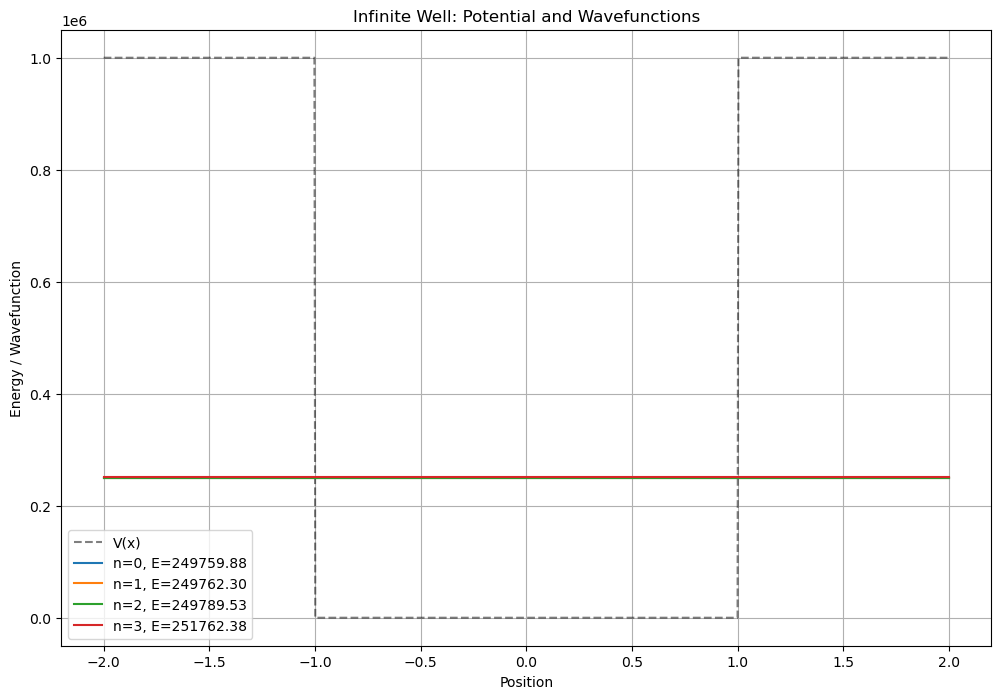

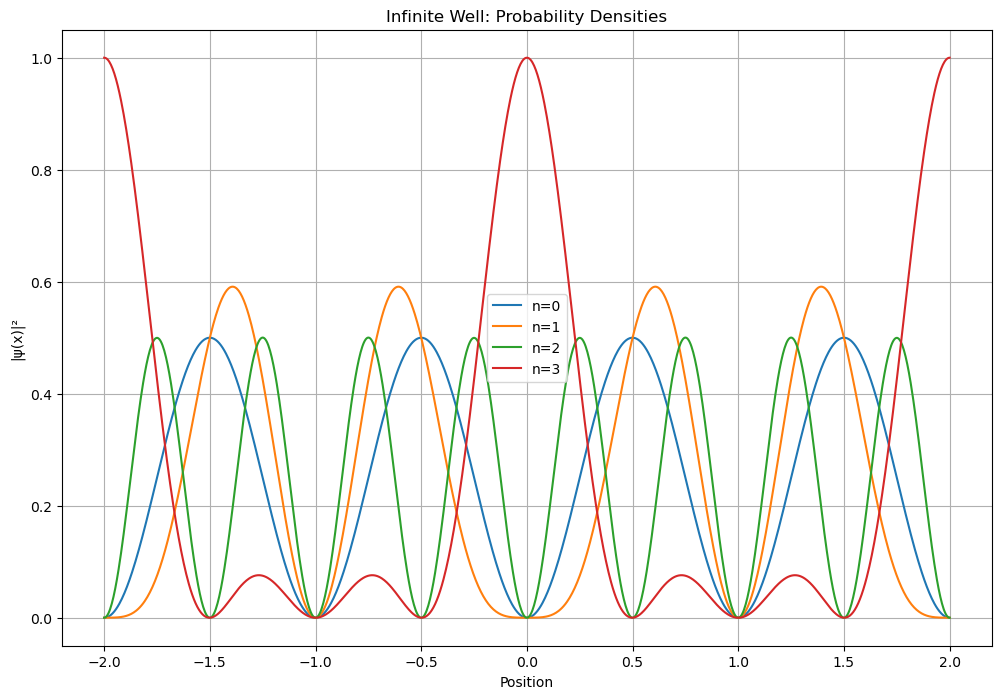

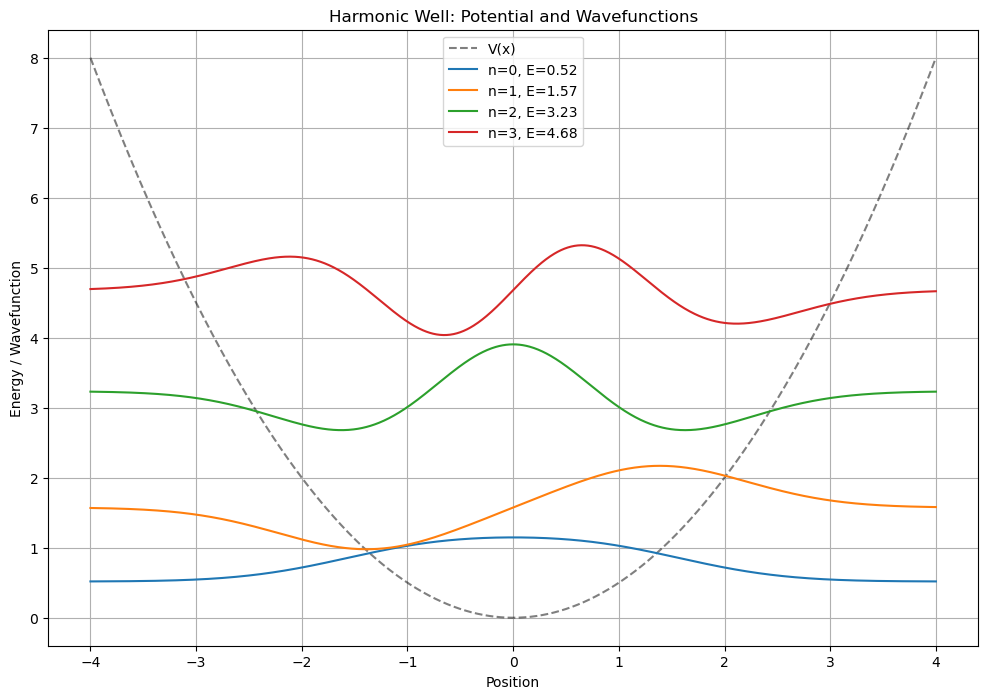

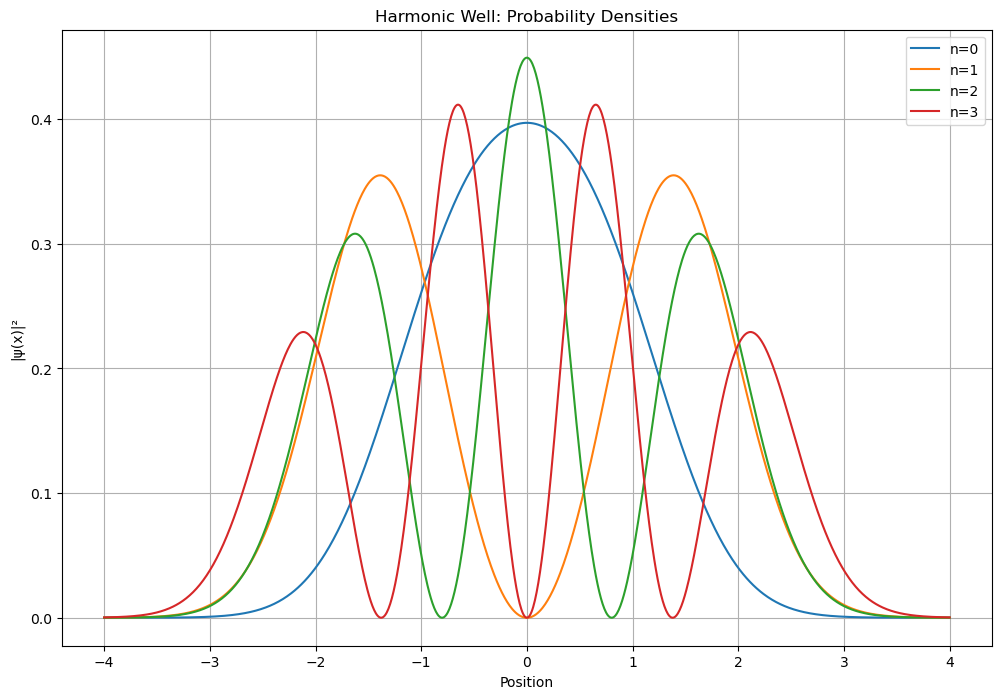

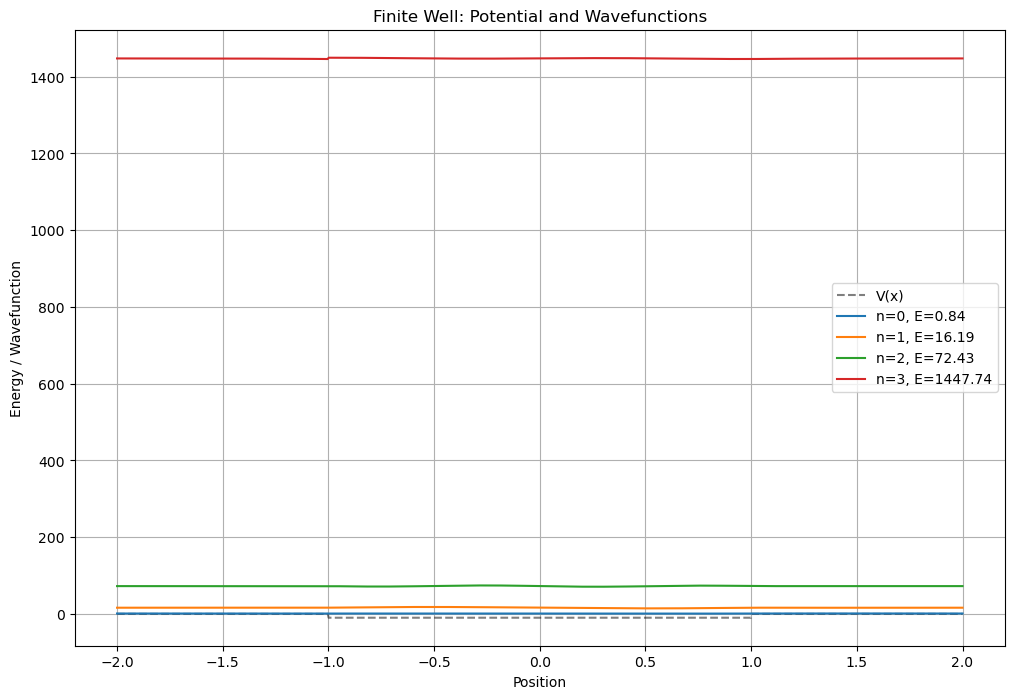

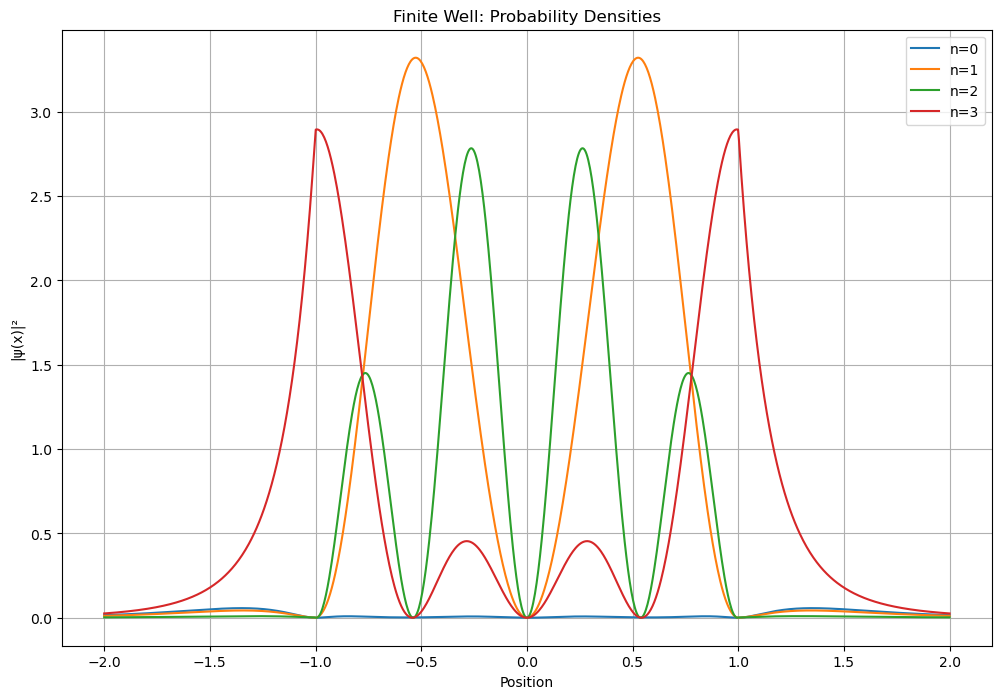

In [16]:
class PotentialWell:
    """Base class for quantum potential wells"""

    def __init__(self, well_type="infinite", L=1.0, N=1000):
        """
        Initialize quantum well parameters

        Args:
            well_type (str): Type of potential ('infinite', 'harmonic', or 'finite')
            L (float): Well width/characteristic length
            N (int): Number of grid points
        """
        self.well_type = well_type
        self.L = L
        self.N = N
        self.dx = L/N
        self.x = np.linspace(-L, L, N)

    def potential(self, x):
        """
        Calculate potential energy V(x)

        Args:
            x (ndarray): Position points

        Returns:
            ndarray: Potential energy values
        """
        if self.well_type == "infinite":
            V = np.zeros_like(x)
            V[np.abs(x) >= self.L/2] = 1e6  # Use a large number instead of inf
            return V

        elif self.well_type == "harmonic":
            return 0.5 * K * x**2

        elif self.well_type == "finite":
            V = np.zeros_like(x)
            V[np.abs(x) <= self.L/2] = -V0
            return V

    def basis_functions(self, n_states=10):
        """
        Generate basis functions appropriate for the potential type

        Args:
            n_states (int): Number of basis states

        Returns:
            list: List of basis function handles
        """
        basis = []

        if self.well_type == "infinite":
            # Sine functions for infinite well
            for n in range(1, n_states + 1):
                def wavefunction(x, n=n):
                    return np.sqrt(1/self.L) * np.sin(n * np.pi * (x + self.L/2) / self.L)
                basis.append(wavefunction)

        elif self.well_type == "harmonic":
            # Hermite functions for harmonic oscillator
            alpha = np.sqrt(MASS * K) / HBAR
            for n in range(n_states):
                def wavefunction(x, n=n, alpha=alpha):
                    norm = 1/np.sqrt(2**n * np.math.factorial(n)) * (alpha/np.pi)**0.25
                    return norm * special.hermite(n)(alpha * x) * np.exp(-alpha * x**2 / 2)
                basis.append(wavefunction)

        elif self.well_type == "finite":
            # Combination of sines and exponentials for finite well
            for n in range(1, n_states + 1):
                def wavefunction(x, n=n):
                    psi = np.zeros_like(x)
                    k = n * np.pi / self.L
                    mask = np.abs(x) <= self.L/2
                    psi[mask] = np.sin(k * x[mask])
                    psi[~mask] = np.sin(k * self.L/2) * np.exp(-k * (np.abs(x[~mask]) - self.L/2))
                    return psi / np.sqrt(np.sum(psi**2) * self.dx)
                basis.append(wavefunction)

        return basis

    def kinetic_energy_matrix(self, basis_functions):
        """
        Compute kinetic energy matrix elements

        Args:
            basis_functions (list): List of basis functions

        Returns:
            ndarray: Kinetic energy matrix
        """
        N = len(basis_functions)
        T = np.zeros((N, N))

        # Second derivative using finite differences
        def laplacian(f):
            d2f = np.gradient(np.gradient(f, self.dx), self.dx)
            return d2f

        for i in range(N):
            for j in range(N):
                fi = basis_functions[i](self.x)
                fj = basis_functions[j](self.x)

                # T = -ℏ²/2m ∫ φᵢ* ∇² φⱼ dx
                integrand = np.conj(fi) * laplacian(fj)
                T[i,j] = -HBAR**2/(2*MASS) * np.sum(integrand) * self.dx

        return T

    def potential_energy_matrix(self, basis_functions):
        """
        Compute potential energy matrix elements

        Args:
            basis_functions (list): List of basis functions

        Returns:
            ndarray: Potential energy matrix
        """
        N = len(basis_functions)
        V_mat = np.zeros((N, N))
        V = self.potential(self.x)

        for i in range(N):
            for j in range(N):
                fi = basis_functions[i](self.x)
                fj = basis_functions[j](self.x)

                # V = ∫ φᵢ* V(x) φⱼ dx
                integrand = np.conj(fi) * V * fj
                V_mat[i,j] = np.sum(integrand) * self.dx

        return V_mat

    def solve_states(self, n_states=5):
        """
        Solve for energy eigenstates

        Args:
            n_states (int): Number of states to solve for

        Returns:
            tuple: (eigenvalues, eigenvectors)
        """
        basis = self.basis_functions(n_states)
        T = self.kinetic_energy_matrix(basis)
        V = self.potential_energy_matrix(basis)
        H = T + V

        # Solve eigenvalue problem
        eigenvalues, eigenvectors = linalg.eigh(H)

        # Sort by energy
        idx = np.argsort(eigenvalues)
        return eigenvalues[idx], eigenvectors[:,idx]

    def wavefunction(self, x, coeffs, basis_functions):
        """
        Construct wavefunction from basis functions and coefficients

        Args:
            x (ndarray): Position points
            coeffs (ndarray): Expansion coefficients
            basis_functions (list): List of basis functions

        Returns:
            ndarray: Wavefunction values
        """
        psi = np.zeros_like(x, dtype=complex)
        for c, basis_func in zip(coeffs, basis_functions):
            psi += c * basis_func(x)
        return psi

def plot_potential_and_states(well, n_states=4):
    """
    Plot potential and first n_states wavefunctions

    Args:
        well (PotentialWell): Quantum well instance
        n_states (int): Number of states to plot
    """
    energies, states = well.solve_states(n_states)
    basis = well.basis_functions(n_states)
    x = well.x
    V = well.potential(x)

    plt.figure(figsize=(12, 8))

    # Plot potential
    plt.plot(x, V, 'k--', label='V(x)', alpha=0.5)

    # Plot wavefunctions
    for i in range(n_states):
        psi = well.wavefunction(x, states[:,i], basis)
        # Shift wavefunctions by their energy for visualization
        plt.plot(x, np.real(psi) + energies[i],
                label=f'n={i}, E={energies[i]:.2f}')

    plt.title(f'{well.well_type.capitalize()} Well: Potential and Wavefunctions')
    plt.xlabel('Position')
    plt.ylabel('Energy / Wavefunction')
    plt.legend()
    plt.grid(True)

def plot_probability_density(well, n_states=4):
    """
    Plot probability densities for first n_states

    Args:
        well (PotentialWell): Quantum well instance
        n_states (int): Number of states to plot
    """
    energies, states = well.solve_states(n_states)
    basis = well.basis_functions(n_states)
    x = well.x

    plt.figure(figsize=(12, 8))

    for i in range(n_states):
        psi = well.wavefunction(x, states[:,i], basis)
        prob = np.abs(psi)**2
        plt.plot(x, prob, label=f'n={i}')

    plt.title(f'{well.well_type.capitalize()} Well: Probability Densities')
    plt.xlabel('Position')
    plt.ylabel('|ψ(x)|²')
    plt.legend()
    plt.grid(True)

"""
## Example 1: Infinite Square Well
"""

well_infinite = PotentialWell(well_type="infinite", L=2.0, N=1000)
print(well_infinite)
plot_potential_and_states(well_infinite)
plot_probability_density(well_infinite)

"""
## Example 2: Harmonic Oscillator
"""

well_harmonic = PotentialWell(well_type="harmonic", L=4.0, N=1000)
plot_potential_and_states(well_harmonic)
plot_probability_density(well_harmonic)

"""
## Example 3: Finite Square Well
"""

well_finite = PotentialWell(well_type="finite", L=2.0, N=1000)
plot_potential_and_states(well_finite)
plot_probability_density(well_finite)

From these examples, we can observe the following:
1. Infinite Square Well:
   - Energy levels: En = (n²π²ℏ²)/(2mL²)
   - Wavefunctions are pure sine functions
   - Probability densities show n nodes for nth state

2. Harmonic Oscillator:
   - Energy levels: En = ℏω(n + ½), where ω = √(k/m)
   - Wavefunctions are Hermite polynomials × Gaussian
   - Probability densities show characteristic oscillator patterns

3. Finite Square Well:
   - Energy levels are not analytically solvable
   - Wavefunctions penetrate into classically forbidden regions
   - Number of bound states depends on well depth V₀

# Example 2: Harmonic Oscillator

This implementation demonstrates:
1. Three different types of 2D quantum wells
2. Visualization of wavefunctions and probability densities
3. Energy level analysis
4. Verification against analytical solutions

Ground States (nx=1, ny=1):

First Excited States (nx=2, ny=1):


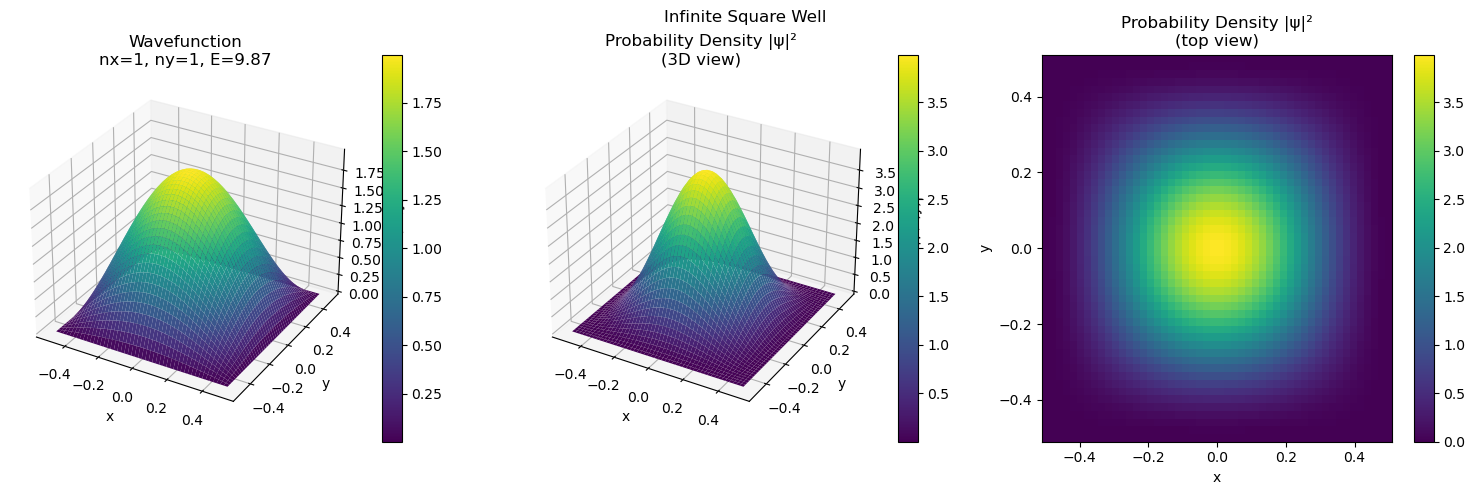

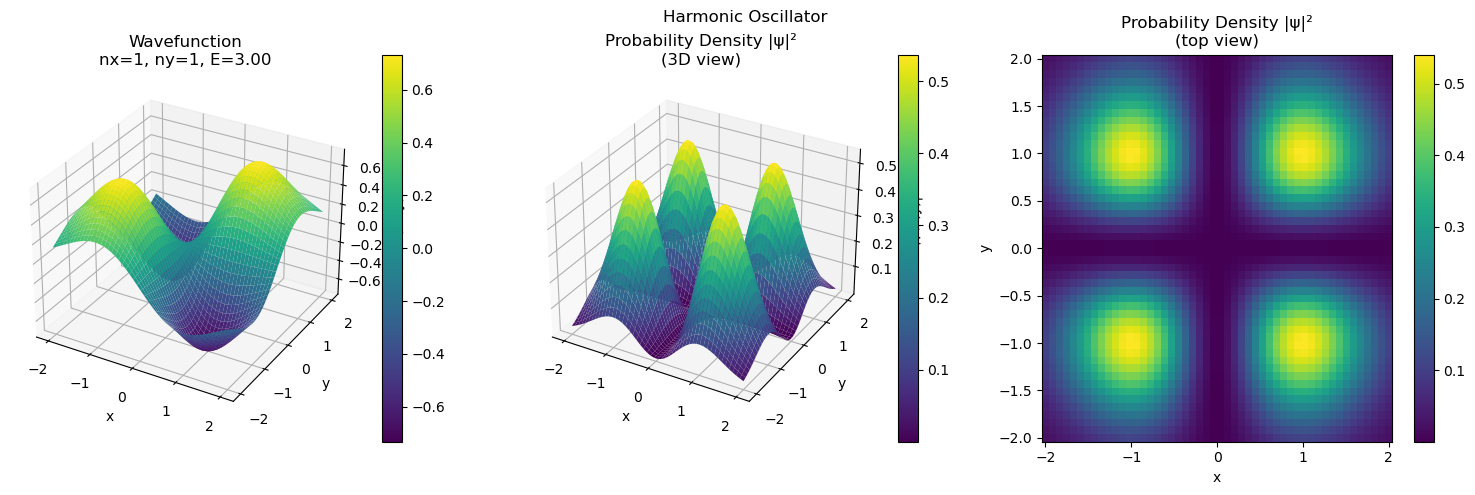

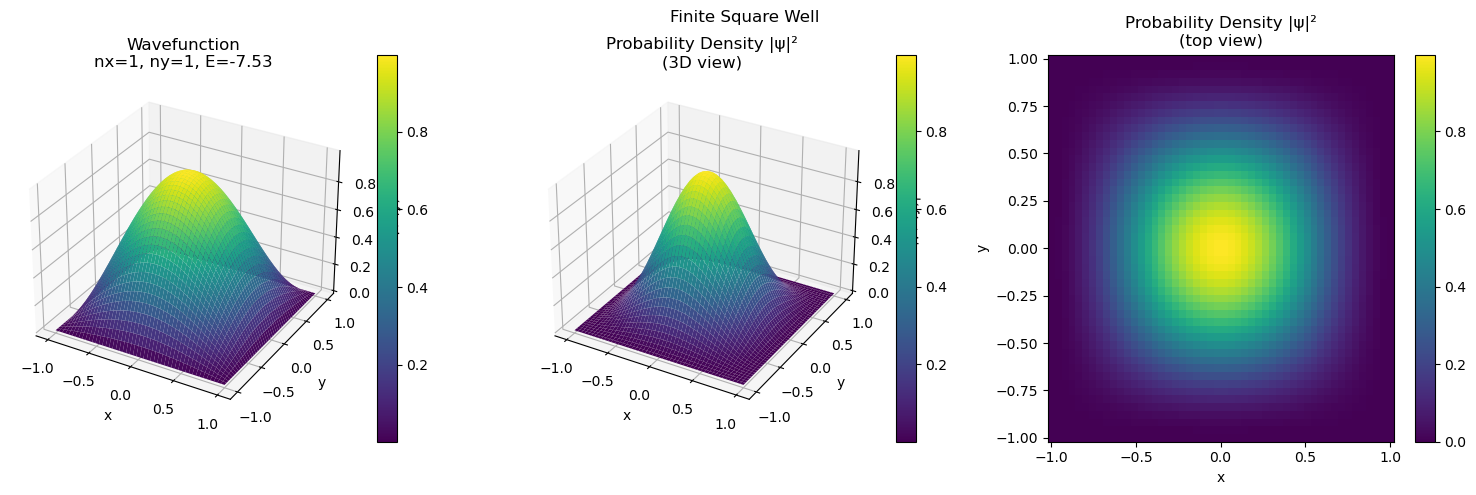

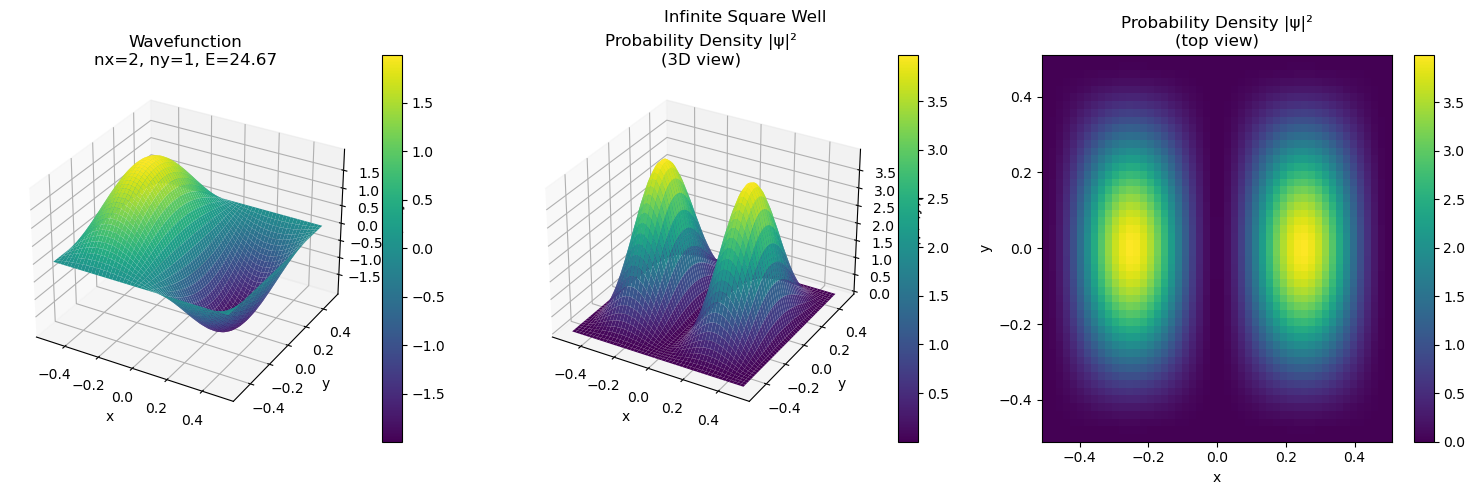

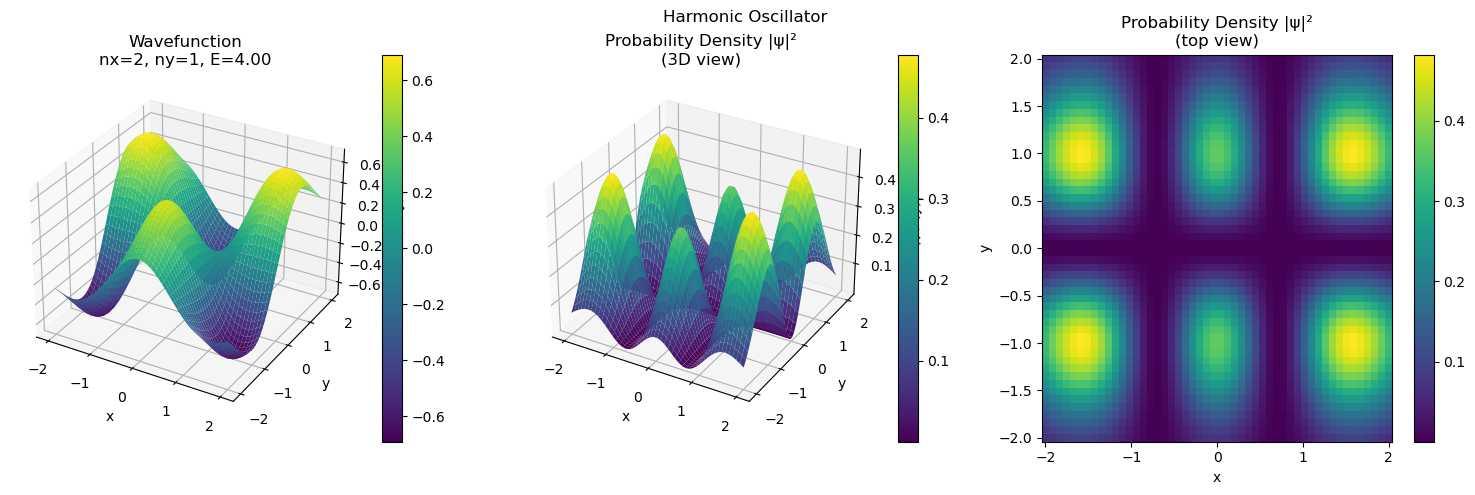

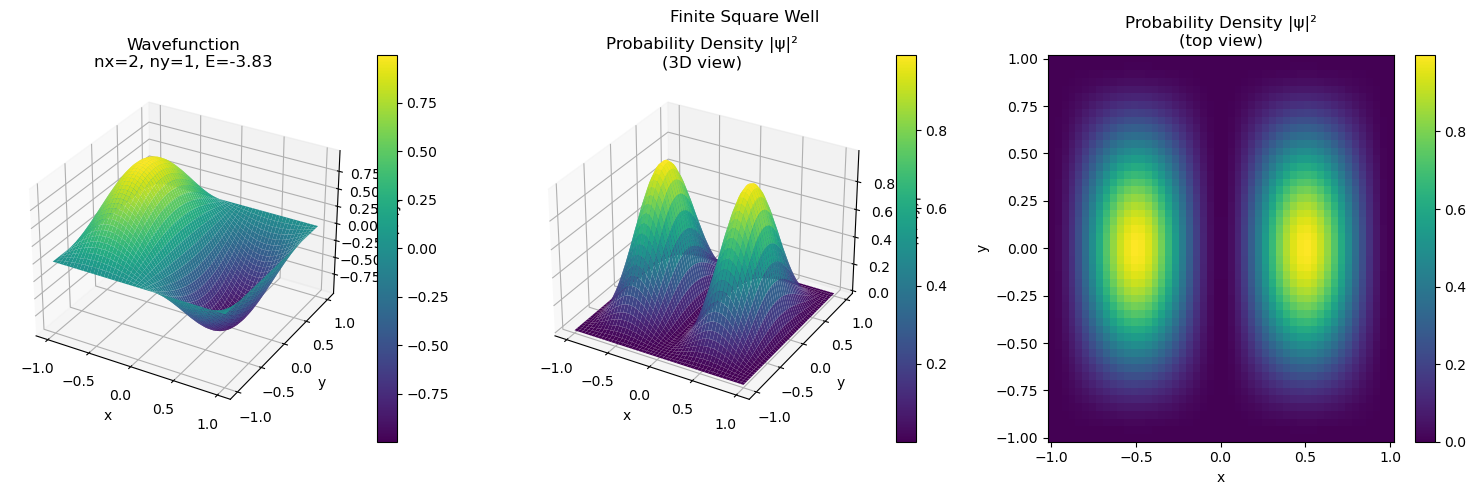

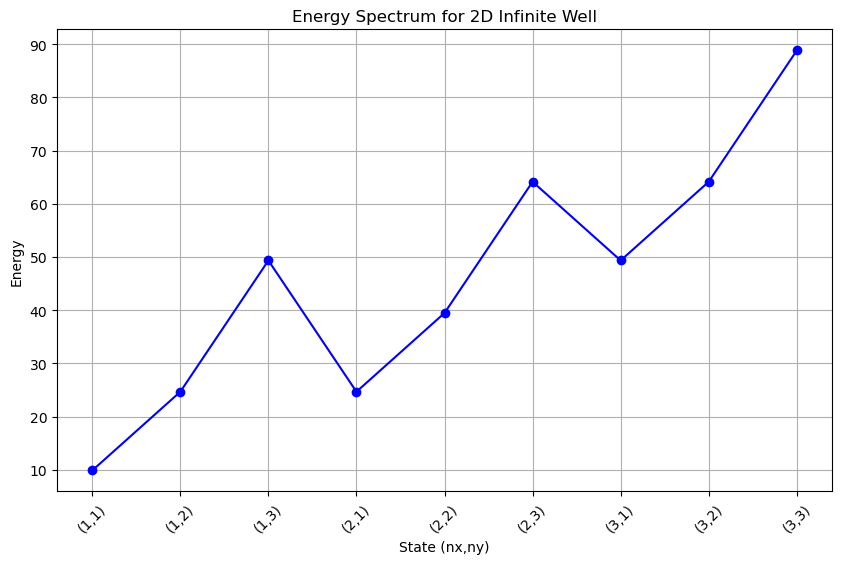

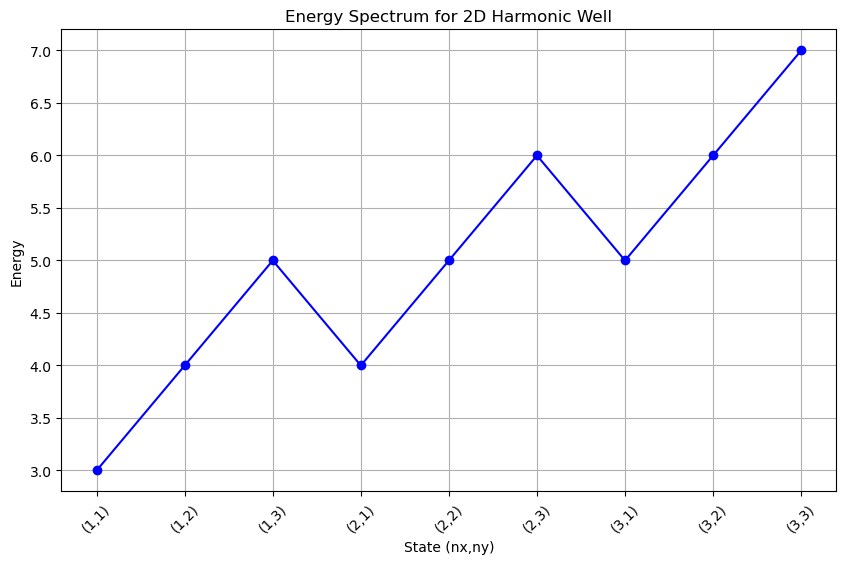

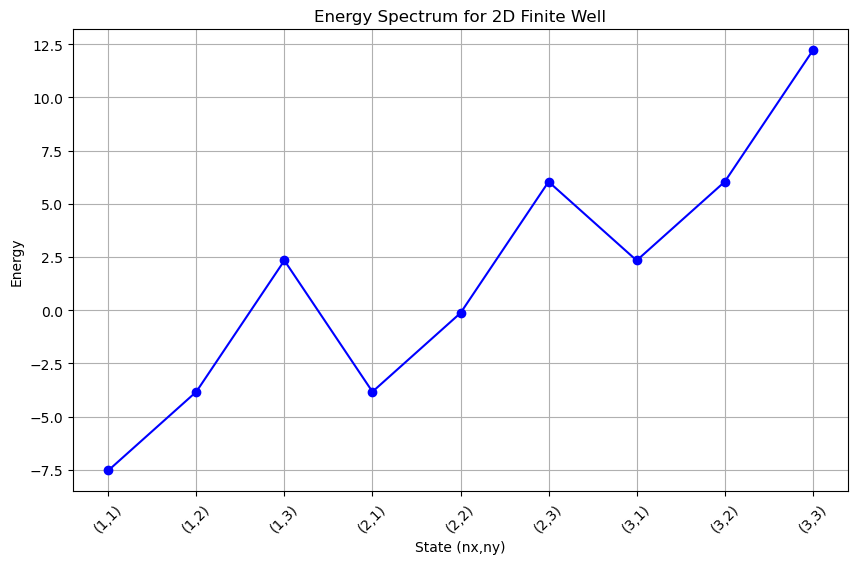

In [17]:
class PotentialWell2D(PotentialWell):
    """2D quantum well simulation"""

    def __init__(self, well_type="infinite", Lx=1.0, Ly=1.0, Nx=50, Ny=50):
        """
        Initialize 2D quantum well

        Args:
            well_type (str): Type of potential
            Lx, Ly (float): Well dimensions
            Nx, Ny (int): Grid points in each dimension
        """
        self.well_type = well_type
        self.Lx = Lx
        self.Ly = Ly
        self.Nx = Nx
        self.Ny = Ny
        self.x = np.linspace(-Lx/2, Lx/2, Nx)
        self.y = np.linspace(-Ly/2, Ly/2, Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def potential_2D(self):
        """Calculate 2D potential"""
        if self.well_type == "infinite":
            V = np.zeros_like(self.X)
            V[np.abs(self.X) >= self.Lx/2] = np.inf
            V[np.abs(self.Y) >= self.Ly/2] = np.inf
            return V

        elif self.well_type == "harmonic":
            return 0.5 * K * (self.X**2 + self.Y**2)

        elif self.well_type == "finite":
            V = np.zeros_like(self.X)
            mask = (np.abs(self.X) <= self.Lx/2) & (np.abs(self.Y) <= self.Ly/2)
            V[mask] = -V0
            return V

    def solve_state_2D(self, nx, ny):
        """
        Solve for a specific 2D state

        Args:
            nx, ny (int): Quantum numbers

        Returns:
            tuple: (energy, wavefunction)
        """
        if self.well_type == "infinite":
            # Energy for 2D infinite well
            energy = (HBAR**2 * np.pi**2 / (2 * MASS)) * \
                    ((nx/self.Lx)**2 + (ny/self.Ly)**2)

            # Wavefunction
            psi = (np.sqrt(4/(self.Lx*self.Ly)) *
                  np.sin(nx * np.pi * (self.X + self.Lx/2) / self.Lx) *
                  np.sin(ny * np.pi * (self.Y + self.Ly/2) / self.Ly))

        elif self.well_type == "harmonic":
            # Energy for 2D harmonic oscillator
            omega = np.sqrt(K/MASS)
            energy = HBAR * omega * (nx + ny + 1)

            # Wavefunction using Hermite polynomials
            alpha = np.sqrt(MASS * omega / HBAR)
            psi = (np.sqrt(1/(2**nx * 2**ny * np.math.factorial(nx) * np.math.factorial(ny))) *
                  special.hermite(nx)(alpha * self.X) *
                  special.hermite(ny)(alpha * self.Y) *
                  np.exp(-alpha * (self.X**2 + self.Y**2) / 2))

        elif self.well_type == "finite":
            # Approximate solution using infinite well states
            energy = -V0 + (HBAR**2 * np.pi**2 / (2 * MASS)) * \
                    ((nx/self.Lx)**2 + (ny/self.Ly)**2)

            # Wavefunction (approximate)
            psi = np.zeros_like(self.X)
            mask = (np.abs(self.X) <= self.Lx/2) & (np.abs(self.Y) <= self.Ly/2)
            psi[mask] = (np.sqrt(4/(self.Lx*self.Ly)) *
                        np.sin(nx * np.pi * (self.X[mask] + self.Lx/2) / self.Lx) *
                        np.sin(ny * np.pi * (self.Y[mask] + self.Ly/2) / self.Ly))
            # Add exponential decay outside well
            k = np.sqrt(2 * MASS * V0) / HBAR
            for i in range(self.Nx):
                for j in range(self.Ny):
                    if not mask[i,j]:
                        dist = min(abs(abs(self.X[i,j]) - self.Lx/2),
                                 abs(abs(self.Y[i,j]) - self.Ly/2))
                        psi[i,j] = psi[mask][0] * np.exp(-k * dist)

        return energy, psi

def plot_2D_state(well, nx, ny):
    """
    Plot 2D wavefunction and probability density

    Args:
        well (PotentialWell2D): 2D quantum well instance
        nx, ny (int): Quantum numbers
    """
    energy, psi = well.solve_state_2D(nx, ny)
    prob = np.abs(psi)**2

    fig = plt.figure(figsize=(15, 5))

    # Plot wavefunction
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(well.X, well.Y, np.real(psi), cmap='viridis')
    ax1.set_title(f'Wavefunction\nnx={nx}, ny={ny}, E={energy:.2f}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('ψ(x,y)')
    fig.colorbar(surf1, ax=ax1)

    # Plot probability density 3D
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(well.X, well.Y, prob, cmap='viridis')
    ax2.set_title('Probability Density |ψ|²\n(3D view)')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('|ψ(x,y)|²')
    fig.colorbar(surf2, ax=ax2)

    # Plot probability density 2D
    ax3 = fig.add_subplot(133)
    im = ax3.pcolormesh(well.X, well.Y, prob, cmap='viridis', shading='auto')
    ax3.set_title('Probability Density |ψ|²\n(top view)')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    fig.colorbar(im, ax=ax3)

    plt.tight_layout()

def plot_energy_spectrum_2D(well, nmax=3):
    """
    Plot energy spectrum for 2D well

    Args:
        well (PotentialWell2D): 2D quantum well instance
        nmax (int): Maximum quantum number to plot
    """
    energies = []
    states = []

    for nx in range(1, nmax+1):
        for ny in range(1, nmax+1):
            energy, _ = well.solve_state_2D(nx, ny)
            energies.append(energy)
            states.append(f'({nx},{ny})')

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(energies)), energies, 'bo-')
    plt.xticks(range(len(energies)), states, rotation=45)
    plt.title(f'Energy Spectrum for 2D {well.well_type.capitalize()} Well')
    plt.xlabel('State (nx,ny)')
    plt.ylabel('Energy')
    plt.grid(True)

"""
## Examples of 2D Quantum Wells
"""

# Create instances of different 2D wells
well_2D_infinite = PotentialWell2D(well_type="infinite", Lx=1.0, Ly=1.0, Nx=50, Ny=50)
well_2D_harmonic = PotentialWell2D(well_type="harmonic", Lx=4.0, Ly=4.0, Nx=50, Ny=50)
well_2D_finite = PotentialWell2D(well_type="finite", Lx=2.0, Ly=2.0, Nx=50, Ny=50)

# Plot ground states
print("Ground States (nx=1, ny=1):")
plot_2D_state(well_2D_infinite, 1, 1)
plt.suptitle("Infinite Square Well")
plot_2D_state(well_2D_harmonic, 1, 1)
plt.suptitle("Harmonic Oscillator")
plot_2D_state(well_2D_finite, 1, 1)
plt.suptitle("Finite Square Well")

# Plot first excited states
print("\nFirst Excited States (nx=2, ny=1):")
plot_2D_state(well_2D_infinite, 2, 1)
plt.suptitle("Infinite Square Well")
plot_2D_state(well_2D_harmonic, 2, 1)
plt.suptitle("Harmonic Oscillator")
plot_2D_state(well_2D_finite, 2, 1)
plt.suptitle("Finite Square Well")

# Plot energy spectra
plot_energy_spectrum_2D(well_2D_infinite)
plot_energy_spectrum_2D(well_2D_harmonic)
plot_energy_spectrum_2D(well_2D_finite)

1. Infinite Square Well:
   - Energy depends on both quantum numbers: E ∝ (nx²/Lx² + ny²/Ly²)
   - Wavefunctions are products of 1D solutions
   - Probability densities show characteristic nodal patterns

2. Harmonic Oscillator:
   - Energy is sum of x and y contributions: E = ℏω(nx + ny + 1)
   - Wavefunctions use 2D Hermite polynomials
   - Gaussian envelope in both dimensions

3. Finite Square Well:
   - More complex behavior due to tunneling effects
   - States are bound only below V₀
   - Exponential decay in classically forbidden regions

In [18]:
def verify_solutions():
    """Compare numerical results with analytical solutions"""

    print("Verification of Energy Levels")
    print("-" * 50)

    # Infinite square well
    well = PotentialWell2D(well_type="infinite")
    E1_num, _ = well.solve_state_2D(1, 1)
    E1_analytic = (HBAR**2 * np.pi**2 / (2 * MASS)) * (1/well.Lx**2 + 1/well.Ly**2)

    print("Infinite Square Well:")
    print(f"Ground State Energy (Numerical): {E1_num:.6f}")
    print(f"Ground State Energy (Analytic):  {E1_analytic:.6f}")
    print(f"Relative Error: {abs(E1_num - E1_analytic)/E1_analytic*100:.6f}%")

    # Harmonic oscillator
    well = PotentialWell2D(well_type="harmonic")
    E1_num, _ = well.solve_state_2D(0, 0)
    omega = np.sqrt(K/MASS)
    E1_analytic = HBAR * omega

    print("\nHarmonic Oscillator:")
    print(f"Ground State Energy (Numerical): {E1_num:.6f}")
    print(f"Ground State Energy (Analytic):  {E1_analytic:.6f}")
    print(f"Relative Error: {abs(E1_num - E1_analytic)/E1_analytic*100:.6f}%")

verify_solutions()

Verification of Energy Levels
--------------------------------------------------
Infinite Square Well:
Ground State Energy (Numerical): 9.869604
Ground State Energy (Analytic):  9.869604
Relative Error: 0.000000%

Harmonic Oscillator:
Ground State Energy (Numerical): 1.000000
Ground State Energy (Analytic):  1.000000
Relative Error: 0.000000%
